In [1]:
import torch
import numpy as np
import math
import wandb
import matplotlib.pyplot as plt


from models.moe_layer.resnet.moe_block_layer import MoeBlockLayer
from models.moe_layer.resnet18.resnet18_experts import NarrowResNet18Expert
from models.moe_layer.resnet18.resnet18_moe import ResNet18MoE
from models.moe_layer.soft_gating_networks import SimpleGate
from models.moe_layer.hard_gating_networks import RelativeImportanceGate, AbsoluteImportanceGate
from models.moe_layer.static_gating_networks import EqualWeightGatingNetwork, SingleWeightingGatingNetwork
from datasets.cifar100_dataset import CIFAR100Dataset
from utils.dataset_utils import train_test_split, get_transformation
from utils.cifar100_utils import CIFAR100_LABELS
from utils.visualize_activations import CNNActivationVisualization
from utils.visualize_features import CNNLayerVisualization

In [2]:
# Setting seeds
torch.manual_seed(42)
np.random.seed(42)

# Loading datasets
transformations_test = get_transformation('cifar100', phase='test')
basic_transformation = get_transformation('no_transform')
cifar_test = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test)
cifar_test_no_prep = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=basic_transformation)

In [3]:
# Set model parameters
num_experts = 4
top_k = 2
loss_function = 'kl_divergence'
w_aux_loss = 0.5
in_channels_gate = 256
layer_position = 4

# Load model
file_model = wandb.restore('ResNet18_kl_divergence_w=0.5_moePosition=4_final.tar', run_path='lukas-struppek/resnet18_moe/1pokkiil')

# Create model
gate = SimpleGate(
    in_channels=in_channels_gate, 
    num_experts=num_experts,
    top_k=top_k,
    use_noise=True,
    name='SimpleGate_' + loss_function,
    loss_fkt=loss_function,
    w_aux_loss=w_aux_loss
    )
        
moe_layer = MoeBlockLayer(
    num_experts=num_experts, 
    layer_position=layer_position, 
    top_k=top_k,
    gating_network=gate,
    resnet_expert=NarrowResNet18Expert)

model = ResNet18MoE(
    moe_layers=[moe_layer],
    name='ResNet18',
)

# Load parameters
model.load_state_dict(torch.load(file_model.name)['model_state_dict'])

# Move model to cuda
model.to(model.device)

# Reference to moe layer after loading parameters
moe_layer = model.layers[3]

In [4]:
# Which samples result in largest weights
indices_list, weight_list = model.get_gating_weights(cifar_test, moe_layer, top_k=3)
print(indices_list)

[array([6942,  735, 7571]), array([8606, 9214,  392]), array([1925, 9075, 1978]), array([3882, 5597, 9760])]


In [5]:
index=8606

In [6]:
# Review gating weights for different classes
df = model.mean_weights_per_class(moe_layer)

for expert in range(4):
    print(df.sort_values(by='expert ' + str(expert), ascending=False)[:5])
    print()

label  expert 0  expert 1  expert 2  expert 3
62    poppy  0.872638  0.049836  0.007347  0.070179
92    tulip  0.835670  0.050545  0.007712  0.106074
70     rose  0.834282  0.064551  0.020269  0.080898
36  hamster  0.768378  0.118988  0.016499  0.096135
53   orange  0.761347  0.230961  0.000000  0.007692

        label  expert 0  expert 1  expert 2  expert 3
20      chair  0.038973  0.931996  0.023029  0.006002
24  cockroach  0.072499  0.827832  0.055306  0.044363
86  telephone  0.083630  0.791322  0.112688  0.012360
16        can  0.245467  0.700517  0.033030  0.020986
94   wardrobe  0.272272  0.691812  0.016171  0.019746

       label  expert 0  expert 1  expert 2  expert 3
52  oak_tree  0.009124  0.017948  0.944622  0.028306
60     plain  0.004011  0.038249  0.943255  0.014485
49  mountain  0.021089  0.013949  0.937389  0.027572
71       sea  0.011090  0.062453  0.920085  0.006372
30   dolphin  0.010402  0.056999  0.841766  0.090833

        label  expert 0  expert 1  expert 2  expe

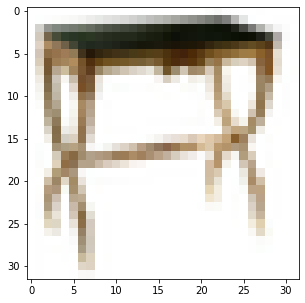

In [7]:
plt.figure(figsize = (5, 5))
plt.imshow(cifar_test_no_prep[index][0].permute(1, 2, 0))

In [8]:
def hook(module, input, output):
    print(torch.nn.functional.softmax(output, dim=1))

In [9]:
handle = moe_layer.gate.register_forward_hook(hook)
model(cifar_test[index][0].unsqueeze(0).to(model.device))
handle.remove()


tensor([[0.0023, 0.9943, 0.0018, 0.0016]], device='cuda:0',
       grad_fn=<SoftmaxBackward>)


[268  99 135 467 463 412   3 391 290]


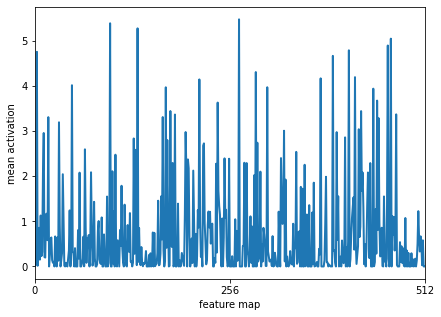

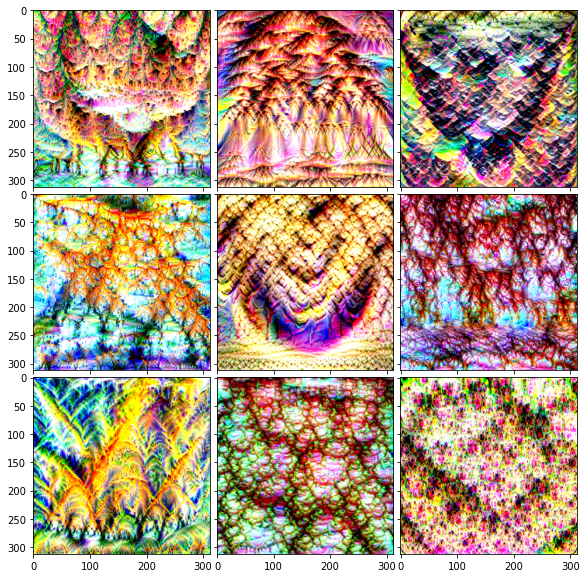

In [10]:
expert = 1

av1 = CNNActivationVisualization(model, moe_layer.experts[expert].model[1])
top_activations = av1.compute_activations(cifar_test[index][0].unsqueeze(0), number_of_filters=512, top_k=9)
print(top_activations)

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  #
                 nrows_ncols=(3, 3),  
                 axes_pad=0.1,  
                 )
images = []
for filter in top_activations:
    moe_layer.gate = EqualWeightGatingNetwork(in_channels_gate, 4)
    lc1 = CNNLayerVisualization(model, moe_layer.experts[expert].model[1], selected_filter=filter, mean=[0.5071, 0.4865, 0.4409], std=[0.2009, 0.1984, 0.2023])
    img = lc1.visualise_layer_with_hooks(init_size=6, scaling_factor=1.2, scaling_steps=25)
    images.append(img)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()


[474 123  99 300 354 126 193 450 349]


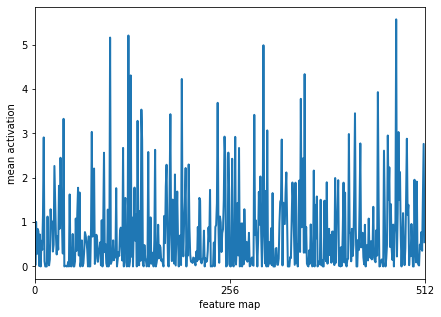

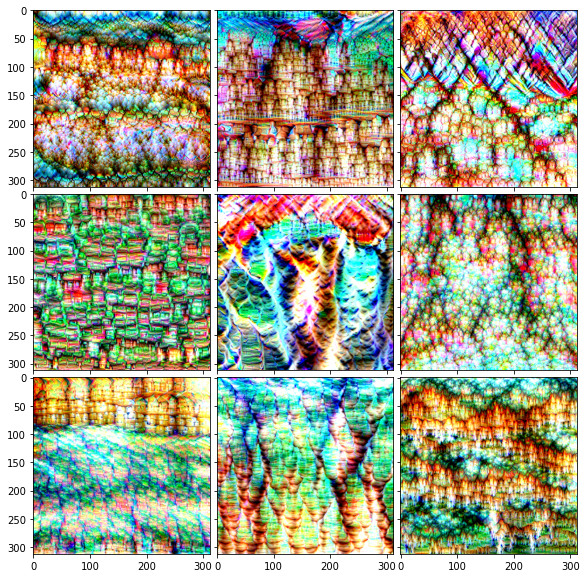

In [11]:
expert = 3

av1 = CNNActivationVisualization(model, moe_layer.experts[expert].model[1])
top_activations = av1.compute_activations(cifar_test[index][0].unsqueeze(0), number_of_filters=512, top_k=9)
print(top_activations)

from mpl_toolkits.axes_grid1 import ImageGrid
fig = plt.figure(figsize=(10, 10))
grid = ImageGrid(fig, 111,  #
                 nrows_ncols=(3, 3),  
                 axes_pad=0.1,  
                 )
images = []
for filter in top_activations:
    moe_layer.gate = EqualWeightGatingNetwork(in_channels_gate, 4)
    lc1 = CNNLayerVisualization(model, moe_layer.experts[expert].model[1], selected_filter=filter, mean=[0.5071, 0.4865, 0.4409], std=[0.2009, 0.1984, 0.2023])
    img = lc1.visualise_layer_with_hooks(init_size=6, scaling_factor=1.2, scaling_steps=25)
    images.append(img)

for ax, im in zip(grid, images):
    ax.imshow(im)

plt.show()


In [12]:
cifar_test_chair = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test, labels=['chair'])

for expert in range(4):
    moe_layer.gate = SingleWeightingGatingNetwork(in_channels_gate, expert_number=expert, num_experts=4)
    print(model.evaluate(cifar_test_chair))

------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.0100
------------------------------------ Finished Evaluation ------------------------------------

{'loss': tensor(11.8008), 'aux_loss': tensor(0., device='cuda:0'), 'acc': 0.01}
------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.8400
------------------------------------ Finished Evaluation ------------------------------------

{'loss': tensor(1.2796), 'aux_loss': tensor(0., device='cuda:0'), 'acc': 0.84}
------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.0100
---------------------------------

In [13]:
cifar_test_flowers = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test, labels=['tulip', 'rose', 'poppy'])
for expert in range(4):
    moe_layer.gate = SingleWeightingGatingNetwork(in_channels_gate, expert_number=expert, num_experts=4)
    print(model.evaluate(cifar_test_chair))


------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.0100
------------------------------------ Finished Evaluation ------------------------------------

{'loss': tensor(11.8008), 'aux_loss': tensor(0., device='cuda:0'), 'acc': 0.01}
------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.8400
------------------------------------ Finished Evaluation ------------------------------------

{'loss': tensor(1.2796), 'aux_loss': tensor(0., device='cuda:0'), 'acc': 0.84}
------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.0100
---------------------------------

In [16]:
cifar_test_flowers = CIFAR100Dataset(
    root_dir='/home/lb4653/mixture-of-experts-thesis/data/cifar100/testing', transform=transformations_test, labels=['apple', 'mushroom', 'orange', 'pear', 'sweet_pepper'])
for expert in range(4):
    moe_layer.gate = SingleWeightingGatingNetwork(in_channels_gate, expert_number=expert, num_experts=4)
    print(model.evaluate(cifar_test_chair))


------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.0100
------------------------------------ Finished Evaluation ------------------------------------

{'loss': tensor(11.8008), 'aux_loss': tensor(0., device='cuda:0'), 'acc': 0.01}
------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.8400
------------------------------------ Finished Evaluation ------------------------------------

{'loss': tensor(1.2796), 'aux_loss': tensor(0., device='cuda:0'), 'acc': 0.84}
------------------------------------ Beginning Evaluation ------------------------------------
Evaluation of  ResNet18
Evaluation on 100 samples
Evaluation complete in  00:00:00
Evaluation Accuracy: 0.0100
---------------------------------